# Procedural Generation of Networks
## Sigmoid Approximation
> __Purpose__: The goal of this notebook is to set the stage for procedurally generating neural networks, specifically by approximating the steady state values using sigmoid functions, instead of relying on experimentalyl determined alpha and beta functions.  This serves to reduce the number of parameters required needed to generate another neuron, and also to limit the function space we are working in (i.e. we are saying that all steady state values must follow some sigmoid function, as opposed to any arbitrary function).



> Ritt email summary:
1. Ion channels will have a max tau of around 4 probably
2. How do those values compare to the graphs of the original inverse rate functions? That is, thinking of the values as (constant) functions, their graphs should be horizontal lines presumably in the middle of the varying graphs of the HH functions.
    - Keep track of whether I was comparing taus or rates (I think I was consistent)
3. Burn in: extend time very long so there is no transcience.  If oscillations are still occurring, then the oscillations are stable.
4. Possible remedy to oscillations: lower the leak reversal by a small amount
5. Backup plan: set tau's to reasonable values (i.e. 2,0.1,2 were good, but true average may be better), and then change the other parameters instead.  I.e. may have to change conductances
6. Overall plan: make small changes to parameters, keep notes as to whether it leads to good changes (or what changes in general).  More info/explanation in email

In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From NB 10 For Reference

In [2]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h

    return dVdt, dndt, dmdt, dhdt

In [3]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [4]:
def plot_vnmh(x,t,vertIndex=-1,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')
    
    #Extract variables from matrix
    if x.shape[1] == 4:
        V = x[:,0]
        n = x[:,1]
        m = x[:,2]
        h = x[:,3]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V)
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n,label="n")
            plt.plot(t,m,label="m")
            plt.plot(t,h,label="h")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()
        
    elif x.shape[0] == 10:
        V1 = x[0]
        n1 = x[1]
        m1 = x[2]
        h1 = x[3]
        s1 = x[4]
        V2 = x[5]
        n2 = x[6]
        m2 = x[7]
        h2 = x[8]
        s2 = x[9]
            
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            plt.plot(t,n2,label="n2")
            plt.plot(t,m2,label="m2")
            plt.plot(t,h2,label="h2")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()

In [5]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

## Finding the best approximation for sigmoid functions

In [6]:
#set ICs
V = x0[0]
n = x0[1]
m = x0[2]
h = x0[3]

#Constants
#Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
#conductances (S is Siemens)
gbarNa = 1.2 #mS/cm2
gNa = gbarNa*(m**3)*h
gbarK = 0.36 #mS/cm2
gK = gbarK*(n**4)
gbarL = 0.003 #mS/cm2
gL = gbarL

#reversal potentials
ENa = 55.17 #mV
EK = -72.14 #mV
EL = -49.42 #mV
#membrane capacitance
Cm = 0.01 #uF/cm^2

###########################################################################################

numPoints = 80
vRange = np.linspace(-80,60,numPoints)

n_inf = [0] * numPoints
m_inf = [0] * numPoints
h_inf = [0] * numPoints
n_infSIG = [0] * numPoints
m_infSIG = [0] * numPoints
h_infSIG = [0] * numPoints

tau_n = [0] * numPoints
tau_m = [0] * numPoints
tau_h = [0] * numPoints

for idx, V in enumerate(vRange):
    
    #Previous way, want to match this
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    n_inf[idx] = alpha_n / (alpha_n + beta_n)
    m_inf[idx] = alpha_m / (alpha_m + beta_m)
    h_inf[idx] = alpha_h / (alpha_h + beta_h)
    
    tau_n[idx] = 1 / (alpha_n + beta_n)
    tau_m[idx] = 1 / (alpha_m + beta_m)
    tau_h[idx] = 1 / (alpha_h + beta_h)

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -49; V0m = -36; V0h = -55
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 18; sigm = 10; sigh = -8

    n_infSIG[idx] = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_infSIG[idx] = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_infSIG[idx] = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_nSIG = 2
    tau_mSIG = 0.1
    tau_hSIG = 2

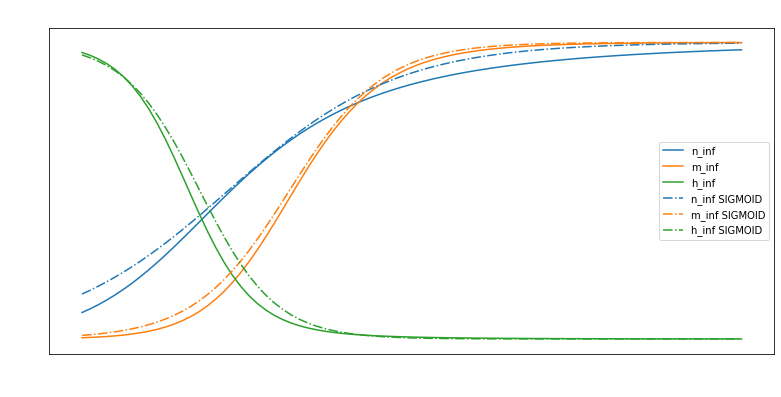

In [46]:
#Font sizes
title_font = 20
label_font = 15

colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'

plt.figure(figsize=(13,6))
plt.title("Steady State Values as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Steady State Value", fontsize=label_font)
plt.xlabel("Volts (mV)", fontsize=label_font)
plt.plot(vRange,n_inf,label="n_inf",color=colors_arr[0])
plt.plot(vRange,m_inf,label="m_inf",color=colors_arr[1])
plt.plot(vRange,h_inf,label="h_inf",color=colors_arr[2])

plt.plot(vRange,n_infSIG,dashed1,label="n_inf SIGMOID",color=colors_arr[0])
plt.plot(vRange,m_infSIG,dashed1,label="m_inf SIGMOID",color=colors_arr[1])
plt.plot(vRange,h_infSIG,dashed1,label="h_inf SIGMOID",color=colors_arr[2])
leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

## Plotting time constants of original HH model
> Note that the time constants (which are essentially rates, should we invert them to have 1/s) are not sigmoid functions.  We will not try to use sigmoid functions, but instead see if we can recreate the neuronal activity using a constant time constant value.  If not we will switch to some kind of function.

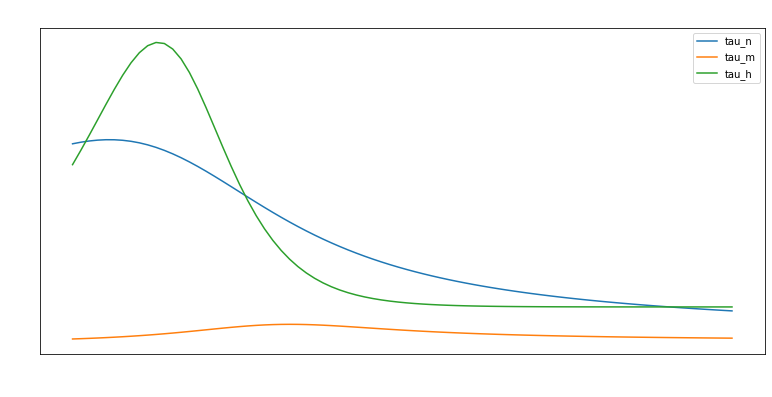

In [15]:
#Font sizes
title_font = 20
label_font = 15

plt.figure(figsize=(13,6))
plt.title("Time Constant as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Time Constant (ms)", fontsize=label_font)
plt.xlabel("Volts (mV)", fontsize=label_font)
plt.plot(vRange,tau_n,label="tau_n")
plt.plot(vRange,tau_m,label="tau_m")
plt.plot(vRange,tau_h,label="tau_h")
leg = plt.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

## Comparing Original HH to Sigmoid Approx
1. Original HH, using odes from NB 10

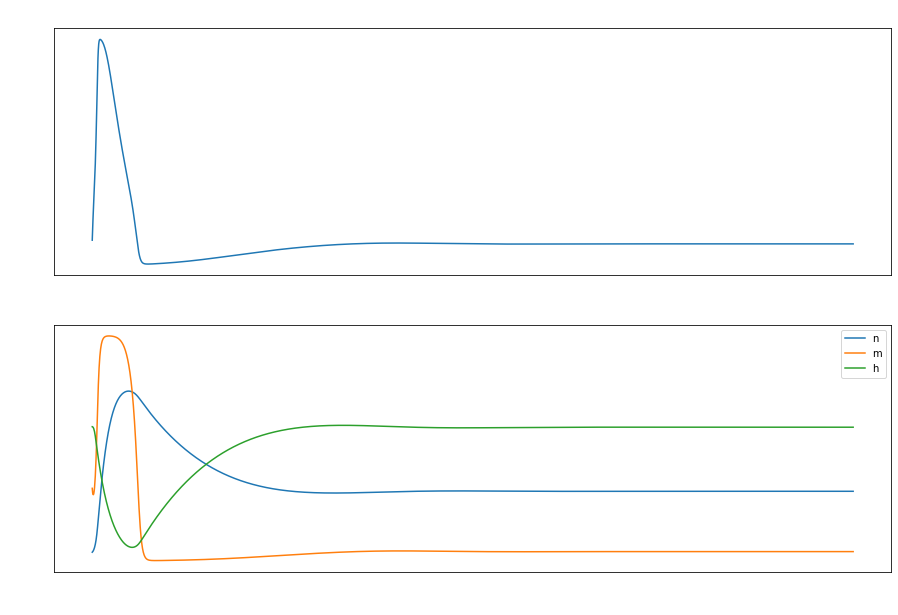

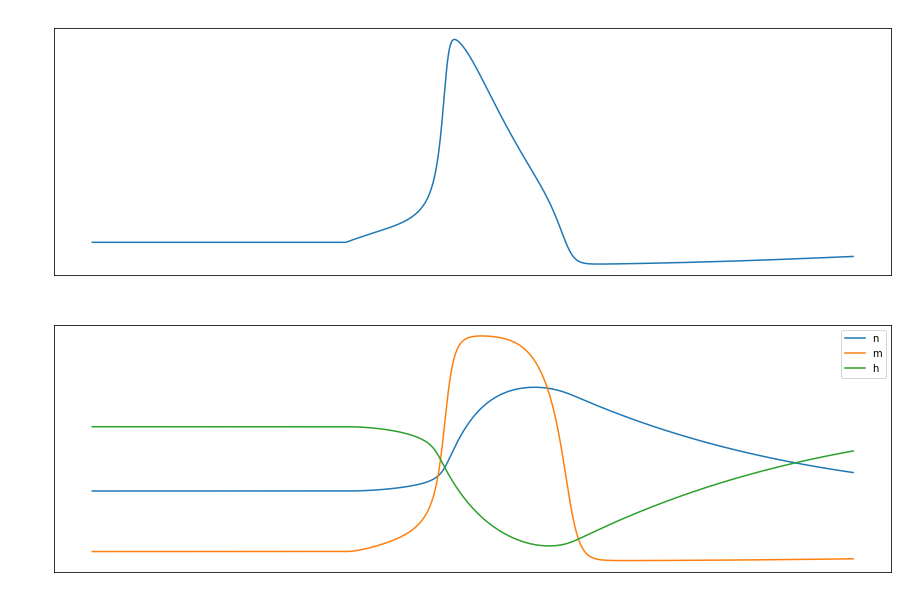

In [9]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))
plot_vnmh(x,t,gatingVars=True)

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t,gatingVars=True)

2. Using sigmoid approximations

In [8]:
def odes_sigmoid(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''

    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]

    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL

    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -49; V0m = -36; V0h = -55
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 18; sigm = 10; sigh = -8

    n_inf = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_inf = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_inf = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_n = 3
    tau_m = 0.1
    tau_h = 4

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = (1/tau_n)*(n_inf - n)
    dmdt = (1/tau_m)*(m_inf - m)
    dhdt = (1/tau_h)*(h_inf - h)

    return dVdt, dndt, dmdt, dhdt

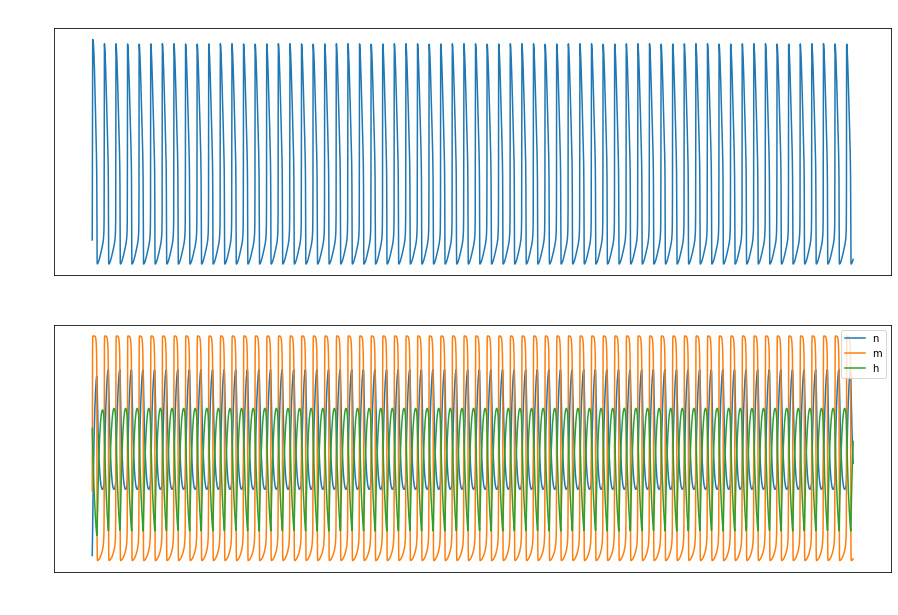

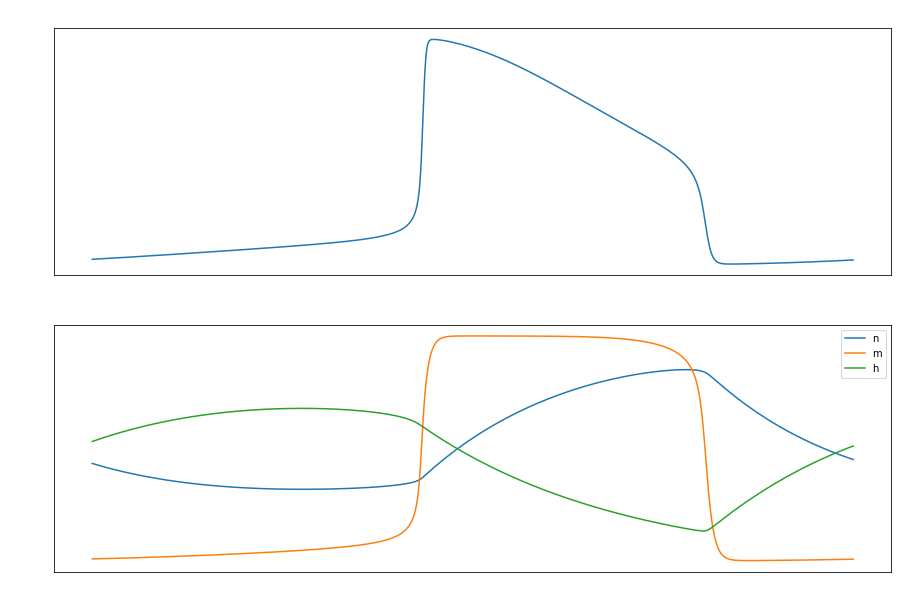

In [11]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,1000,5000)
#vector needed 
vI = [0,0,0]

x = odeint(odes_sigmoid,x0,t,args=(I,vI))
plot_vnmh(x,t,gatingVars=True)

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
#vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes_sigmoid,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t,gatingVars=True)

# Current Issue
- Finding acceptable values for the time constants so that (when no current is applied), we don't observe oscillations.

In [6]:
def odes_sigmoid_TEST(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''

    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]

    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL

    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -49; V0m = -36; V0h = -55
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 18; sigm = 10; sigh = -8

    n_inf = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_inf = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_inf = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_n = vI[3] #1
    tau_m = vI[4] #1
    tau_h = vI[5] #1

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = (1/tau_n)*(n_inf - n)
    dmdt = (1/tau_m)*(m_inf - m)
    dhdt = (1/tau_h)*(h_inf - h)

    return dVdt, dndt, dmdt, dhdt

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


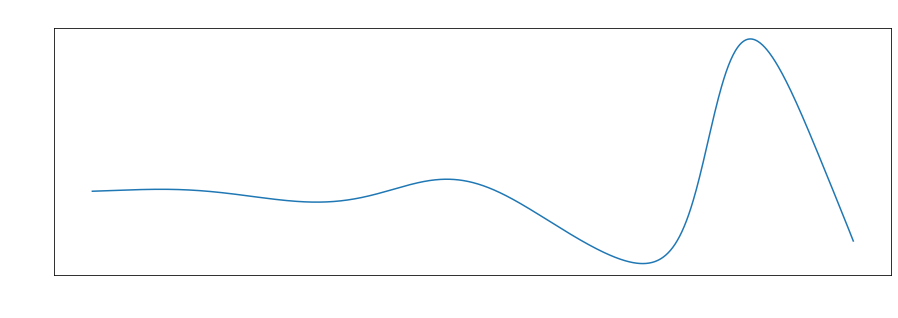

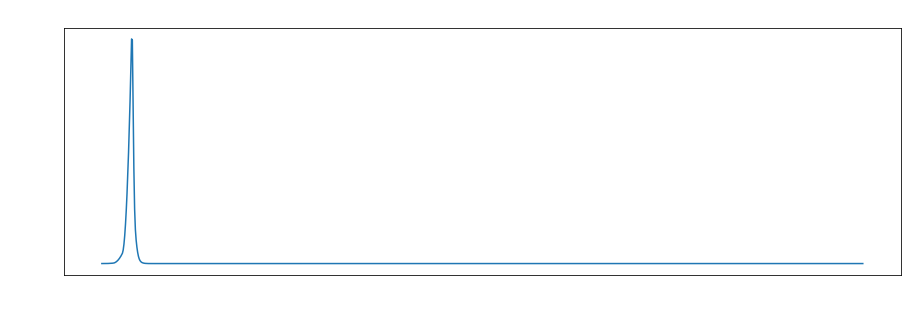

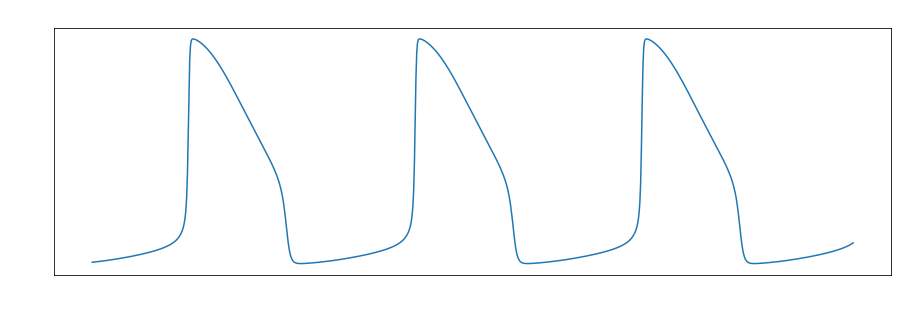

In [28]:
vIE = [0] * 3
vIE[0] = [0,0,0,20,1,5]
vIE[1] = [0,0,0,1,1,1]
vIE[2] = [0,0,0,2,0.1,2]



#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,1000) #600
vI = vIE[0] ############### CHANGE THIS LINE #######################
x = odeint(odes_sigmoid_TEST,x0,t,args=(I,vI))
#plot_vnmh(x,t,gatingVars=True)
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
x0_new = x[-1,:]
#BURNED IN initial condition #vI = [5,7,0.1]
t = np.linspace(0,30,1000)
x = odeint(odes_sigmoid_TEST,x0_new,t,args=(I,vI))
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
plot_vnmh(x,t)#,gatingVars=True)
print("-------------------------------------------------------------------------------")

#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,1000) #600
vI = vIE[1] ############### CHANGE THIS LINE #######################
x = odeint(odes_sigmoid_TEST,x0,t,args=(I,vI))
#plot_vnmh(x,t,gatingVars=True)
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
x0_new = x[-1,:]
#BURNED IN initial condition #vI = [5,7,0.1]
t = np.linspace(0,30,1000)
x = odeint(odes_sigmoid_TEST,x0_new,t,args=(I,vI))
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
plot_vnmh(x,t)#,gatingVars=True)
print("-------------------------------------------------------------------------------")

#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,50,1000) #600
vI = vIE[2] ############### CHANGE THIS LINE #######################
x = odeint(odes_sigmoid_TEST,x0,t,args=(I,vI))
#plot_vnmh(x,t,gatingVars=True)
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
x0_new = x[-1,:]
#BURNED IN initial condition #vI = [5,7,0.1]
t = np.linspace(0,30,1000)
x = odeint(odes_sigmoid_TEST,x0_new,t,args=(I,vI))
V = x[:,0];n = x[:,1];m = x[:,2];h = x[:,3]
plot_vnmh(x,t)#,gatingVars=True)

In [ ]:
tauRange = np.linspace(0,30,15)
found = 0

for tauN in tauRange:
    for tauM in tauRange:
        for tauH in tauRange:
            
            #initial condition: V, n, m, h
            x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
            #time vector
            t = np.linspace(0,50,1000) #600
            vI = [0,0,0,tauN,tauM,tauH]

            x = odeint(odes_sigmoid_TEST,x0,t,args=(I,vI))
            #plot_vnmh(x,t,gatingVars=True)
            V = x[:,0]
            n = x[:,1]
            m = x[:,2]
            h = x[:,3]
            x0_new = x[-1,:]
            #BURNED IN initial condition
            #vI = [5,7,0.1]
            t = np.linspace(0,30,1000)
            x = odeint(odes_sigmoid_TEST,x0_new,t,args=(I,vI))
            V = x[:,0]
            n = x[:,1]
            m = x[:,2]
            h = x[:,3]
            #plot_vnmh(x,t,gatingVars=True)

            AP_threshold = 60
            V = V.tolist()
            max_val = max(V)
            min_val = min(V)
            max_idx = V.index(max_val)
            my_string = "Taus: {tauN:.0f}, {tauM:.0f}, {tauH:.0f}, trial num {total: .0f}/3375"
            print(my_string.format(tauN=tauN,tauM=tauM,tauH=tauH,total=tauN+tauM+tauH))

            #Walk forward until we reach where the AP has come back down to -40 or so
            reboundedIdx = 0
            for nextidx, nextV in enumerate(V[max_idx:]):
                if (nextV<=-40):
                    reboundedIdx = nextidx
            #Find max post AP
            VpostAP = V[reboundedIdx:]
            maxPostAP = max(VpostAP)
            #See if there a high value (ie above 0 since resting is about -60 mV) in the second half
            if (max_val-min_val>AP_threshold) and (maxPostAP < 20):
                print("Potentially found an instance without oscillations?")
                plot_vnmh(x,t)
                print("--------------------------------")
                found = 1
                break
            else:
                print("No 2nd peak found")
                print("--------------------------------")
    
if found==0:
    plot_vnmh(x_scn,t)